<a href="https://colab.research.google.com/github/segnig/ml4fraud-ecommerce-banking/blob/task-2/models/modelling_fraud_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Modelling

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')


In [3]:
LABEL_ENCODED_FILE_PATH = '/content/drive/MyDrive/10 Academy/Cleaned_Data_w8&9/Fraud_Data_label_encoded.csv'
ONEHOT_ENCODED_FILE_PATH = '/content/drive/MyDrive/10 Academy/Cleaned_Data_w8&9/Fraud_Data_onehot_encoded.csv'


label_df = pd.read_csv(LABEL_ENCODED_FILE_PATH)
onehot_df = pd.read_csv(ONEHOT_ENCODED_FILE_PATH)

In [4]:
label_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 23 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   user_id                           151112 non-null  int64 
 1   purchase_value                    151112 non-null  int64 
 2   age                               151112 non-null  int64 
 3   class                             151112 non-null  int64 
 4   country                           151112 non-null  int64 
 5   purchase_week                     151112 non-null  int64 
 6   purchase_month                    151112 non-null  int64 
 7   purchase_year                     151112 non-null  int64 
 8   purchase_day                      151112 non-null  int64 
 9   purchase_hour                     151112 non-null  int64 
 10  purchase_dayofweek                151112 non-null  int64 
 11  is_weekend                        151112 non-null  bool  
 12  ti

In [5]:
onehot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 83 columns):
 #   Column                                   Non-Null Count   Dtype 
---  ------                                   --------------   ----- 
 0   user_id                                  151112 non-null  int64 
 1   purchase_value                           151112 non-null  int64 
 2   age                                      151112 non-null  int64 
 3   class                                    151112 non-null  int64 
 4   purchase_week                            151112 non-null  int64 
 5   purchase_month                           151112 non-null  int64 
 6   purchase_year                            151112 non-null  int64 
 7   purchase_day                             151112 non-null  int64 
 8   purchase_hour                            151112 non-null  int64 
 9   purchase_dayofweek                       151112 non-null  int64 
 10  is_weekend                               151

In [6]:
label_df.head()

,user_id,purchase_value,age,class,country,purchase_week,purchase_month,purchase_year,purchase_day,purchase_hour,...,source_Ads,source_Direct,source_SEO,sex_F,sex_M,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari
0,22058,34,39,0,28,16,4,2015,18,2,...,False,False,True,False,True,True,False,False,False,False
1,333320,16,53,0,56,24,6,2015,8,1,...,True,False,False,True,False,True,False,False,False,False
2,1359,15,53,1,56,1,1,2015,1,18,...,False,False,True,False,True,False,False,False,True,False
3,150084,44,41,0,57,19,5,2015,4,13,...,False,False,True,False,True,False,False,False,False,True
4,221365,39,45,0,56,37,9,2015,9,18,...,True,False,False,False,True,False,False,False,False,True


In [7]:
onehot_df.head()

,user_id,purchase_value,age,class,purchase_week,purchase_month,purchase_year,purchase_day,purchase_hour,purchase_dayofweek,...,country_Tunisia,country_Turkey,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Unknown,country_Venezuela,country_Viet Nam,country_other
0,22058,34,39,0,16,4,2015,18,2,5,...,False,False,False,False,False,False,False,False,False,False
1,333320,16,53,0,24,6,2015,8,1,0,...,False,False,False,False,False,True,False,False,False,False
2,1359,15,53,1,1,1,2015,1,18,3,...,False,False,False,False,False,True,False,False,False,False
3,150084,44,41,0,19,5,2015,4,13,0,...,False,False,False,False,False,False,True,False,False,False
4,221365,39,45,0,37,9,2015,9,18,2,...,False,False,False,False,False,True,False,False,False,False


In [8]:
label_df["time_gap_between_purchase_signup"] = pd.to_timedelta(label_df["time_gap_between_purchase_signup"])
onehot_df["time_gap_between_purchase_signup"] = pd.to_timedelta(onehot_df["time_gap_between_purchase_signup"])

In [9]:
label_df["time_gap_between_purchase_signup"] = label_df["time_gap_between_purchase_signup"].dt.total_seconds()
onehot_df["time_gap_between_purchase_signup"] = onehot_df["time_gap_between_purchase_signup"].dt.total_seconds()

In [10]:
label_df.head()

,user_id,purchase_value,age,class,country,purchase_week,purchase_month,purchase_year,purchase_day,purchase_hour,...,source_Ads,source_Direct,source_SEO,sex_F,sex_M,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari
0,22058,34,39,0,28,16,4,2015,18,2,...,False,False,True,False,True,True,False,False,False,False
1,333320,16,53,0,56,24,6,2015,8,1,...,True,False,False,True,False,True,False,False,False,False
2,1359,15,53,1,56,1,1,2015,1,18,...,False,False,True,False,True,False,False,False,True,False
3,150084,44,41,0,57,19,5,2015,4,13,...,False,False,True,False,True,False,False,False,False,True
4,221365,39,45,0,56,37,9,2015,9,18,...,True,False,False,False,True,False,False,False,False,True


## **Modelling**

In [11]:
# List of diverse machine learning classifiers to experiment with:
# - LogisticRegression: Performs linear classification, good for linearly separable data.
# - KNeighborsClassifier: A non-parametric method relying on proximity, useful for small datasets.
# - DecisionTreeClassifier: A tree-based model that splits data based on feature thresholds.
# - RandomForestClassifier: An ensemble of decision trees that reduces overfitting and improves accuracy.
# - LGBMClassifier: A gradient boosting framework that is efficient and handles large datasets well.
# - XGBClassifier: A popular gradient boosting algorithm known for high performance.
# - CatBoostClassifier: CatBoost is effective with categorical features and often achieves high accuracy; verbose=1000 outputs extensive training logs.
models = [
    LogisticRegression(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LGBMClassifier(),
    XGBClassifier(),
    CatBoostClassifier(verbose=1000)
]

In [12]:
class ModelBuilding:
    def __init__(self, models):
        self.models = models
        self.fitted_models = {}

    def fit(self, X_train, y_train):
        for model in self.models:
            model.fit(X_train, y_train)
            self.fitted_models[model.__class__.__name__] = model
        return self.fitted_models


    def get_metrics(self, X_test, y_test):
        metrics = {}
        for model in self.fitted_models.values():
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred) # Corrected variable name
            metrics[model.__class__.__name__] = {
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1
            }
        return metrics

    def get_confusion_matrix(self, X_test, y_test):
        confusion_matrices = {}
        for model in self.fitted_models.values():
            y_pred = model.predict(X_test)
            cm = confusion_matrix(y_test, y_pred)
            confusion_matrices[model.__class__.__name__] = cm
        return confusion_matrices

    def get_classification_report(self, X_test, y_test):
        classification_reports = {}
        for model in self.fitted_models.values():
            y_pred = model.predict(X_test)
            cr = classification_report(y_test, y_pred)
            classification_reports[model.__class__.__name__] = cr
            print(classification_reports)
        return classification_reports

    def get_confusion_matrix_and_classification_report(self, X_test, y_test):
        # their plot for every model on one
        confusion_matrices = {}
        classification_reports = {}
        for model in self.fitted_models.values():
            y_pred = model.predict(X_test)
            cm = confusion_matrix(y_test, y_pred)
            cr = classification_report(y_test, y_pred)
            confusion_matrices[model.__class__.__name__] = cm
            classification_reports[model.__class__.__name__] = cr


        # plot confusion matrix
        for model_name, cm in confusion_matrices.items():
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
            plt.title(f'Confusion Matrix - {model_name}')
            plt.xlabel('Predicted Labels')
            plt.ylabel('True Labels')
            plt.show()

## **WIthout any sampling**

* The dataset contains a feature representing the country, which has been encoded into numerical labels using label encoding. This technique converts categorical country names into integer values, making them suitable for machine learning algorithms that require numerical input.

* The feature encoding process transforms the original categorical data into a format that models can interpret efficiently, while preserving the categorical distinctions without introducing ordinal relationships.



* X_label contains all the feature columns except the target variable 'class' and the identifier 'user_id'.
y_label contains the encoded target label 'class', representing different classes or categories to be predicted.
The dataset is split into training and testing sets with an 80-20 ratio using train_test_split, ensuring that model training and evaluation are performed on distinct data to prevent overfitting.

* Next, a ModelBuilding class is instantiated with a list of diverse machine learning models, including logistic regression, K-nearest neighbors, decision trees, random forests, gradient boosting models like LightGBM, XGBoost, and CatBoost.

* The models are then trained (fit) on the training data, and their performance is evaluated on the test data, providing metrics such as accuracy, precision, recall, or F1-score through the get_metrics method. Additionally, confusion matrices are generated to visualize the models' classification performance across different classes.

* This approach leverages multiple models and techniques to understand how well each performs on predicting the encoded 'country' feature's associated class, facilitating an informed choice of the best-performing model.

In [13]:
X_label = label_df.drop(columns=['class', "user_id"])
y_label = label_df['class']

X_label_train, X_label_test, y_label_train, y_label_test = train_test_split(X_label, y_label, test_size=0.2, random_state=42)

model_builder = ModelBuilding(models)


fitted_models = model_builder.fit(X_label_train, y_label_train)
metrics = model_builder.get_metrics(X_label_test, y_label_test)
confusion_matrices = model_builder.get_confusion_matrix(X_label_test, y_label_test)

[LightGBM] [Info] Number of positive: 11301, number of negative: 109588
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 120889, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093482 -> initscore=-2.271837
[LightGBM] [Info] Start training from score -2.271837
Learning rate set to 0.07982
0:	learn: 0.5817149	total: 76.2ms	remaining: 1m 16s
999:	learn: 0.1485198	total: 41.5s	remaining: 0us


In [14]:
for model_name, metrics_dict in metrics.items():
    print(f"Metrics for {model_name}:")
    for metric_name, value in metrics_dict.items():
        print(f"{metric_name}: {value}")
    print()

Metrics for LogisticRegression:
Accuracy: 0.9265129206233663
Precision: 0.9921752738654147
Recall: 0.22245614035087719
F1 Score: 0.3634279163083978

Metrics for KNeighborsClassifier:
Accuracy: 0.9553651192800185
Precision: 0.978940650925335
Recall: 0.5382456140350877
F1 Score: 0.694589087616029

Metrics for DecisionTreeClassifier:
Accuracy: 0.9035833636634352
Precision: 0.49026171637248933
Recall: 0.5652631578947368
F1 Score: 0.5250977835723598

Metrics for RandomForestClassifier:
Accuracy: 0.9564239155609966
Precision: 1.0
Recall: 0.5378947368421053
F1 Score: 0.6995208761122519

Metrics for LGBMClassifier:
Accuracy: 0.9564239155609966
Precision: 1.0
Recall: 0.5378947368421053
F1 Score: 0.6995208761122519

Metrics for XGBClassifier:
Accuracy: 0.9562915660258743
Precision: 0.9973975276512687
Recall: 0.5378947368421053
F1 Score: 0.6988830635969911

Metrics for CatBoostClassifier:
Accuracy: 0.956390828177216
Precision: 0.999348109517601
Recall: 0.5378947368421053
F1 Score: 0.6993613138686

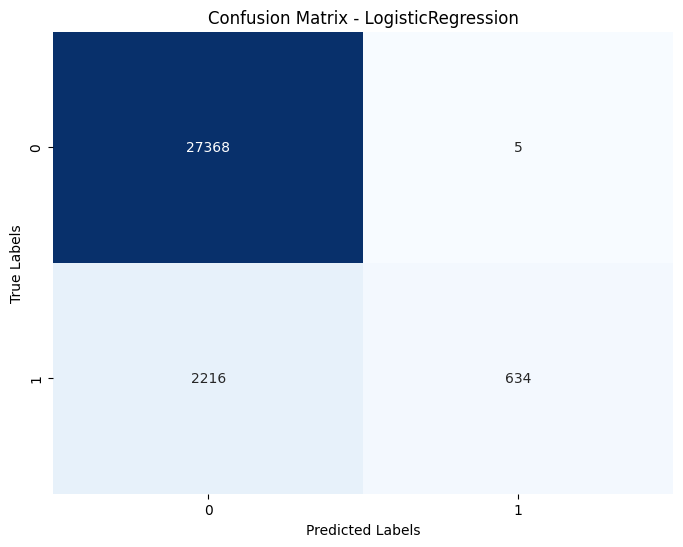

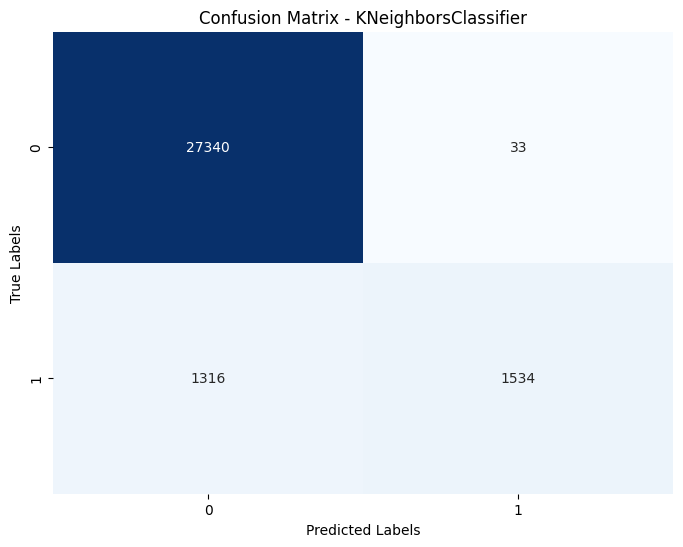

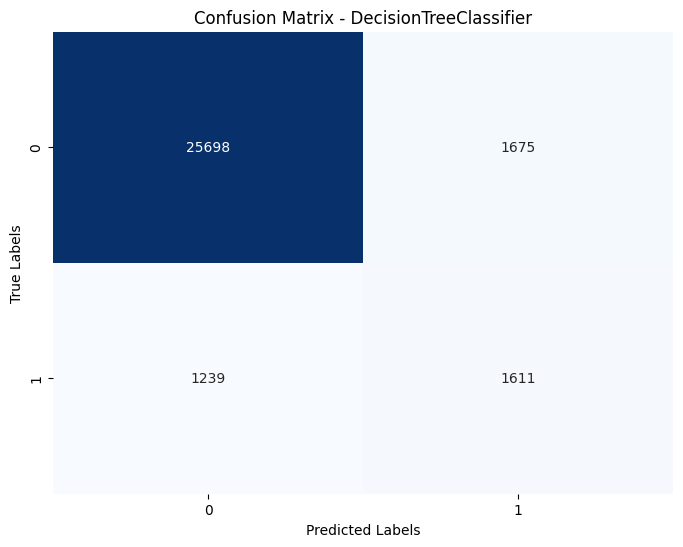

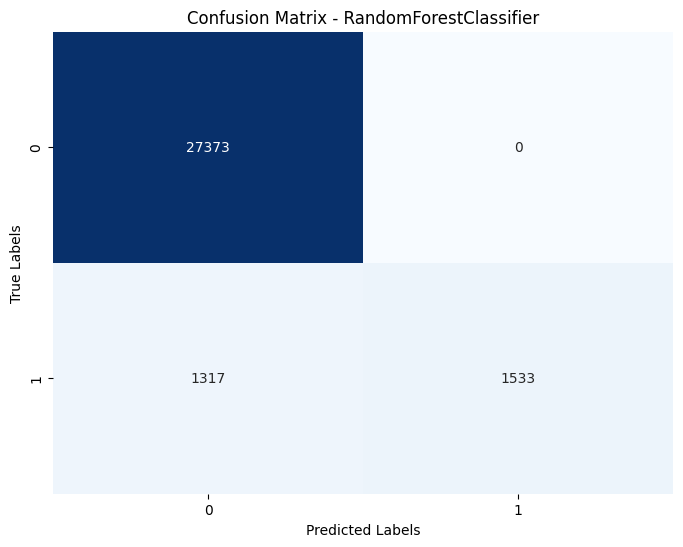

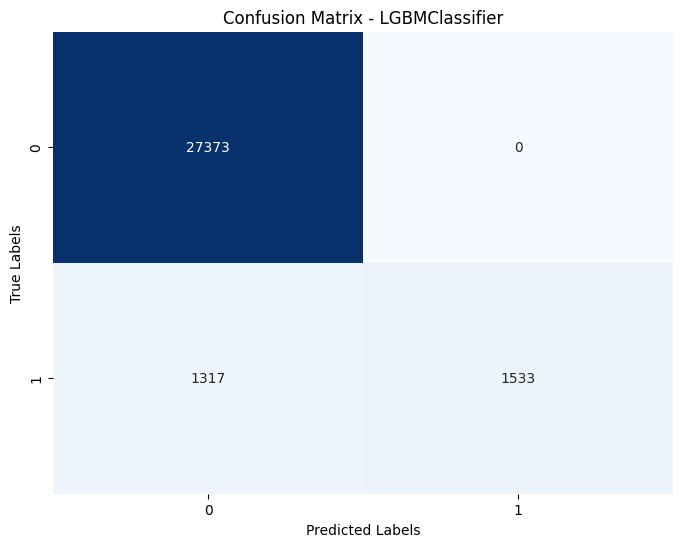

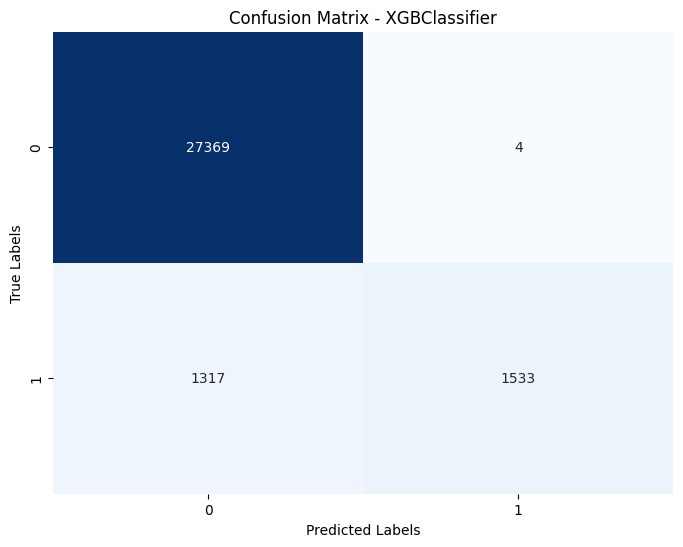

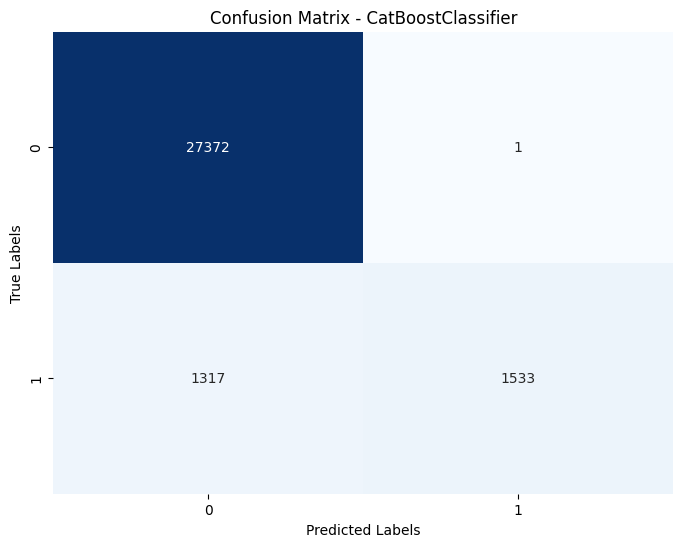

In [15]:
model_builder.get_confusion_matrix_and_classification_report(X_label_test, y_label_test)

## **Oversample**

* Oversampling technique was applied because the dataset has a highly imbalanced class distribution, which can adversely affect the model's performance.

In [16]:
from imblearn.over_sampling import RandomOverSampler

over_sample = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sample.fit_resample(X_label_train, y_label_train)

model_builder = ModelBuilding(models)
fitted_models = model_builder.fit(X_train_over, y_train_over)
metrics = model_builder.get_metrics(X_label_test, y_label_test)
confusion_matrices = model_builder.get_confusion_matrix(X_label_test, y_label_test)

[LightGBM] [Info] Number of positive: 109588, number of negative: 109588
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 219176, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Learning rate set to 0.102909
0:	learn: 0.5847909	total: 96.9ms	remaining: 1m 36s
999:	learn: 0.3050784	total: 1m 2s	remaining: 0us


In [17]:
for model_name, metrics_dict in metrics.items():
    print(f"Metrics for {model_name}:")
    for metric_name, value in metrics_dict.items():
        print(f"{metric_name}: {value}")
    print()

Metrics for LogisticRegression:
Accuracy: 0.7306025212586441
Precision: 0.20645662303084092
Recall: 0.6529824561403509
F1 Score: 0.31372218476062036

Metrics for KNeighborsClassifier:
Accuracy: 0.8455811798961056
Precision: 0.325790987535954
Recall: 0.596140350877193
F1 Score: 0.4213267203967762

Metrics for DecisionTreeClassifier:
Accuracy: 0.9125169572841876
Precision: 0.5341738553417386
Recall: 0.5649122807017544
F1 Score: 0.5491132332878581

Metrics for RandomForestClassifier:
Accuracy: 0.9563246534096549
Precision: 0.998046875
Recall: 0.5378947368421053
F1 Score: 0.6990424076607387

Metrics for LGBMClassifier:
Accuracy: 0.9557952552691659
Precision: 0.9871299871299871
Recall: 0.5382456140350877
F1 Score: 0.6966394187102634

Metrics for XGBClassifier:
Accuracy: 0.9378288058763193
Precision: 0.7236296637494243
Recall: 0.5512280701754386
F1 Score: 0.625771758613822

Metrics for CatBoostClassifier:
Accuracy: 0.9457697779836548
Precision: 0.818852027382833
Recall: 0.5456140350877193
F1

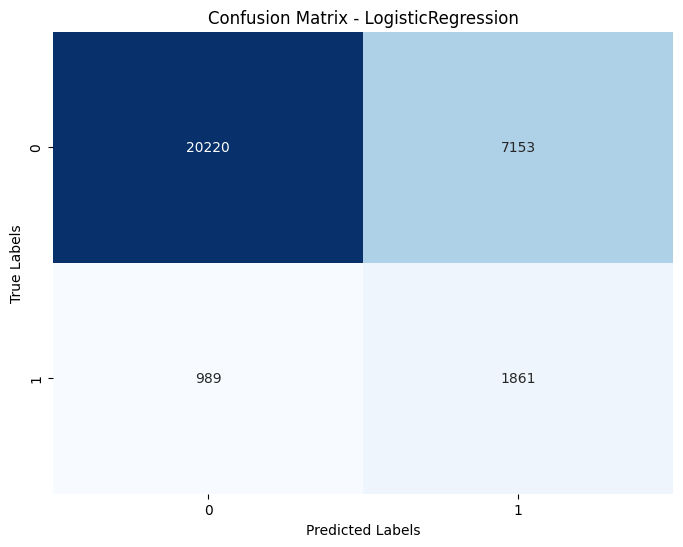

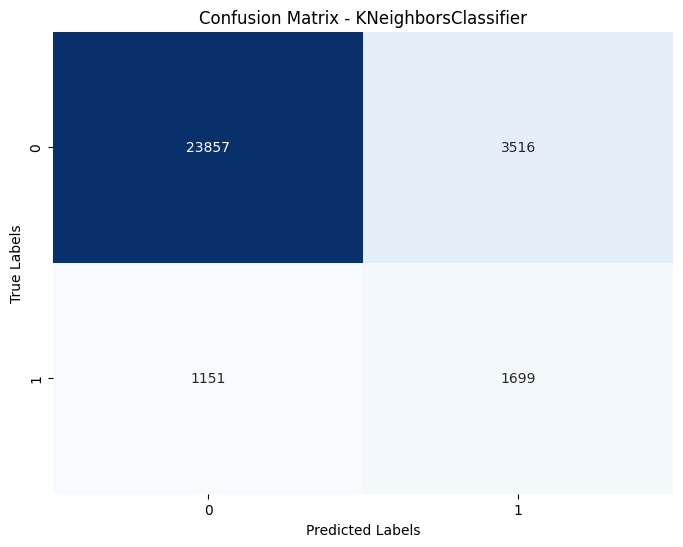

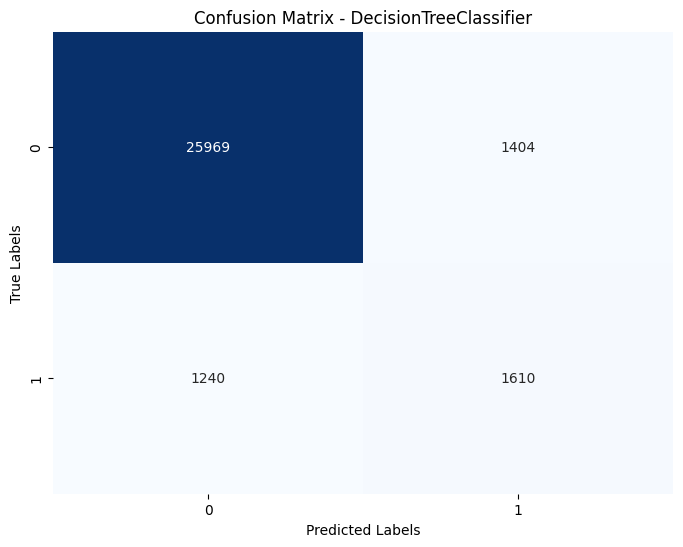

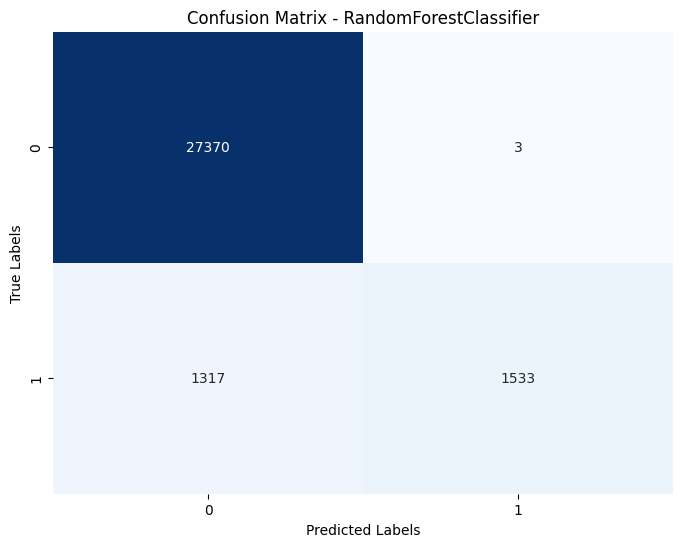

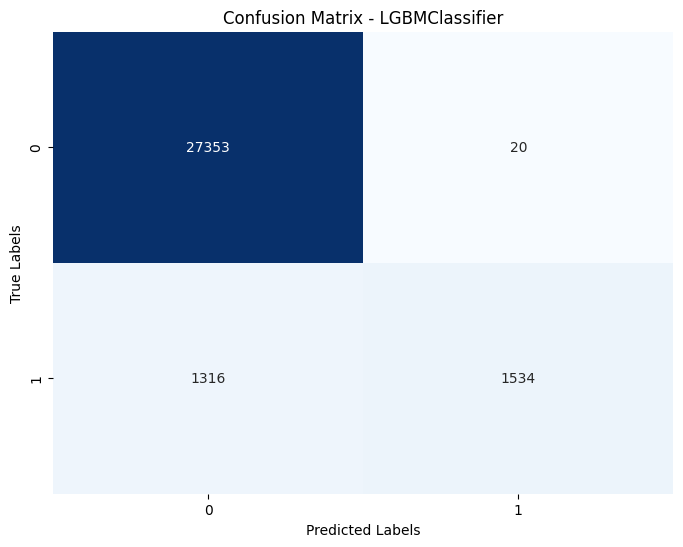

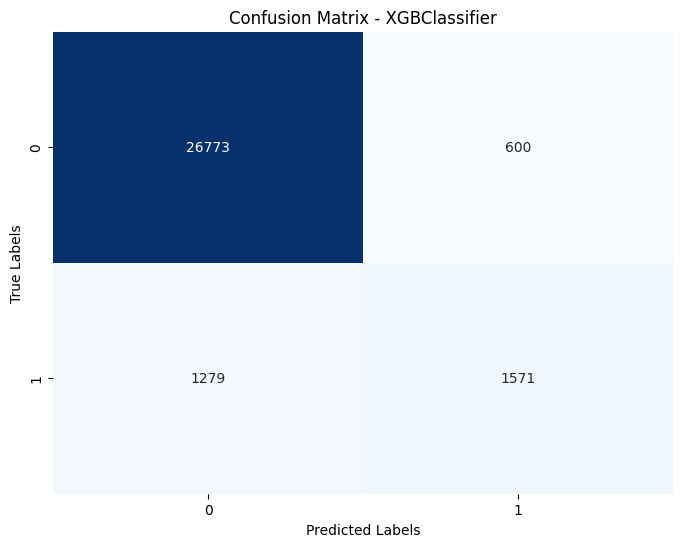

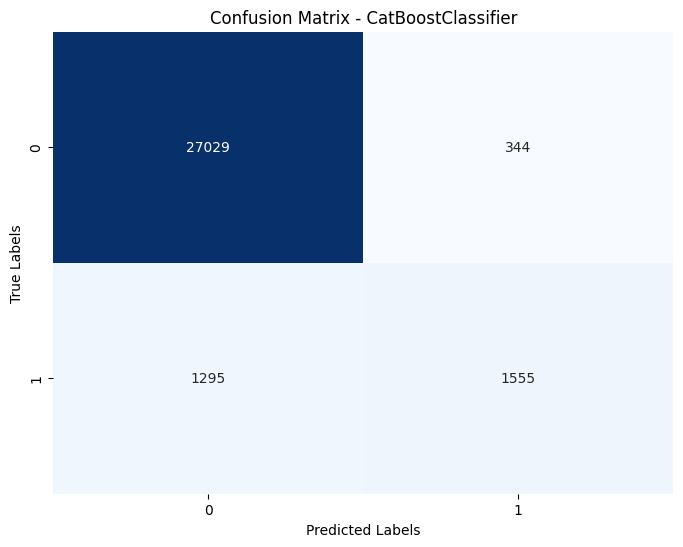

In [18]:
model_builder.get_confusion_matrix_and_classification_report(X_label_test, y_label_test)

## **Under Sampling**

under sampling technique

In [20]:
from imblearn.under_sampling import RandomUnderSampler

under_sample = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under_sample.fit_resample(X_label_train, y_label_train)

model_builder = ModelBuilding(models)
fitted_models = model_builder.fit(X_train_under, y_train_under)
metrics = model_builder.get_metrics(X_label_test, y_label_test)
confusion_matrices = model_builder.get_confusion_matrix(X_label_test, y_label_test)

[LightGBM] [Info] Number of positive: 11301, number of negative: 11301
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 615
[LightGBM] [Info] Number of data points in the train set: 22602, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Learning rate set to 0.039008
0:	learn: 0.6509537	total: 9.04ms	remaining: 9.03s
999:	learn: 0.3780765	total: 10.4s	remaining: 0us


In [21]:
for model_name, metrics_dict in metrics.items():
    print(f"Metrics for {model_name}:")
    for metric_name, value in metrics_dict.items():
        print(f"{metric_name}: {value}")
    print()

Metrics for LogisticRegression:
Accuracy: 0.73387817225292
Precision: 0.20868394479973074
Recall: 0.6526315789473685
F1 Score: 0.3162458556490691

Metrics for KNeighborsClassifier:
Accuracy: 0.7969758131224564
Precision: 0.2593026662760035
Recall: 0.6210526315789474
F1 Score: 0.36585365853658536

Metrics for DecisionTreeClassifier:
Accuracy: 0.6713761042914337
Precision: 0.1799530007230658
Recall: 0.6985964912280702
F1 Score: 0.28618657467299125

Metrics for RandomForestClassifier:
Accuracy: 0.9375971941898554
Precision: 0.7206959706959707
Recall: 0.5522807017543859
F1 Score: 0.6253476360746921

Metrics for LGBMClassifier:
Accuracy: 0.9490785163617113
Precision: 0.8651810584958217
Recall: 0.5449122807017543
F1 Score: 0.6686759956942949

Metrics for XGBClassifier:
Accuracy: 0.8851867782814413
Precision: 0.42143943233654335
Recall: 0.5835087719298245
F1 Score: 0.4894055326662743

Metrics for CatBoostClassifier:
Accuracy: 0.9418654666975482
Precision: 0.769610261470153
Recall: 0.547368421

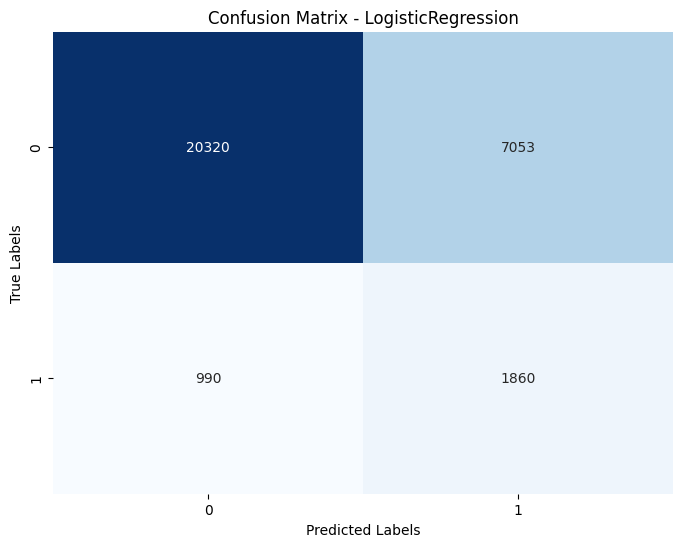

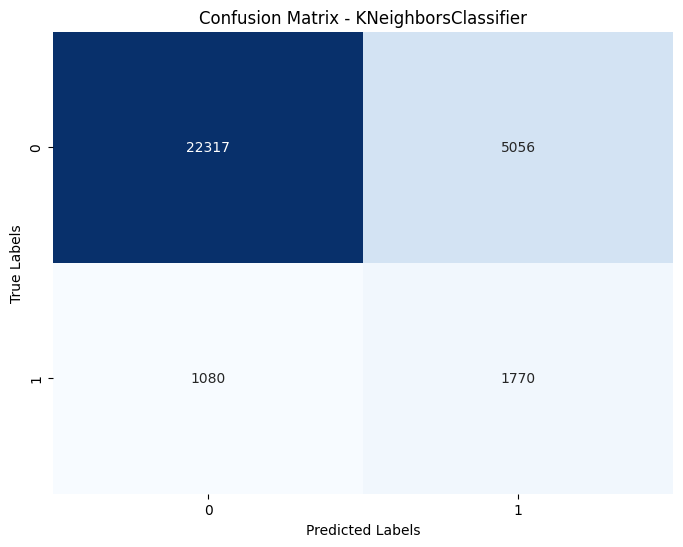

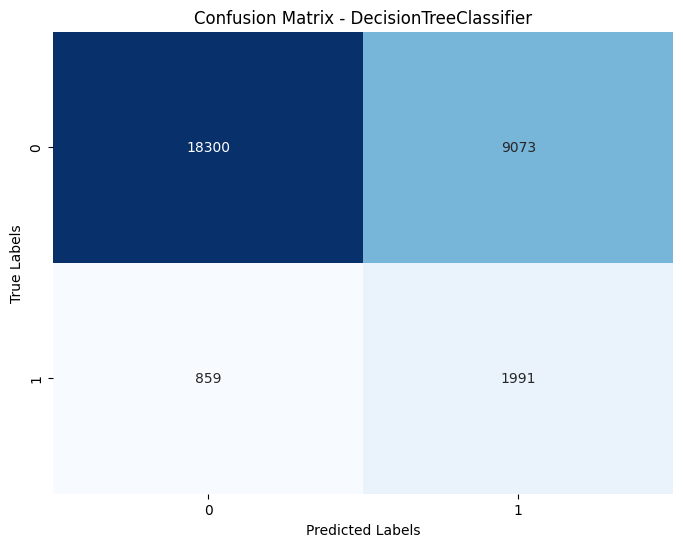

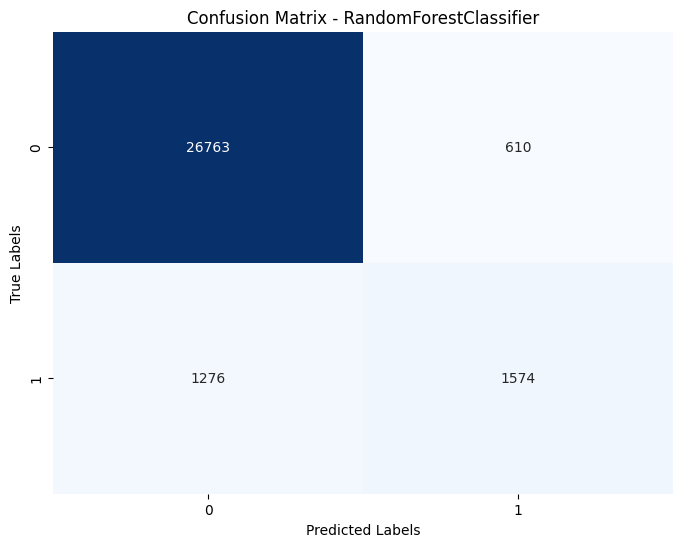

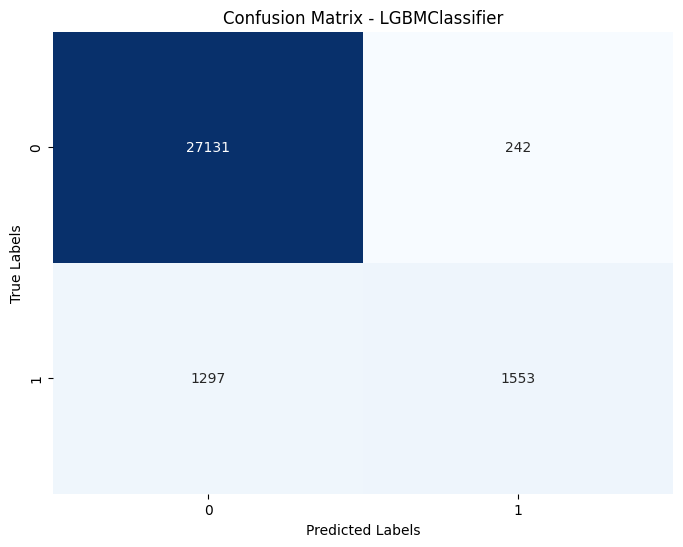

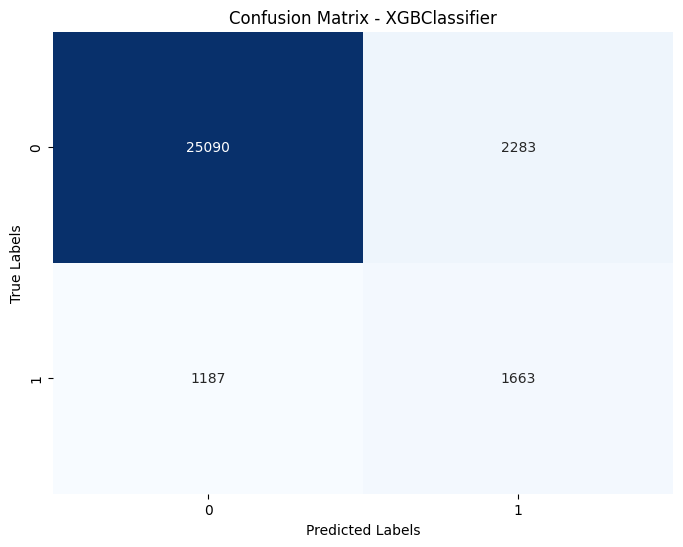

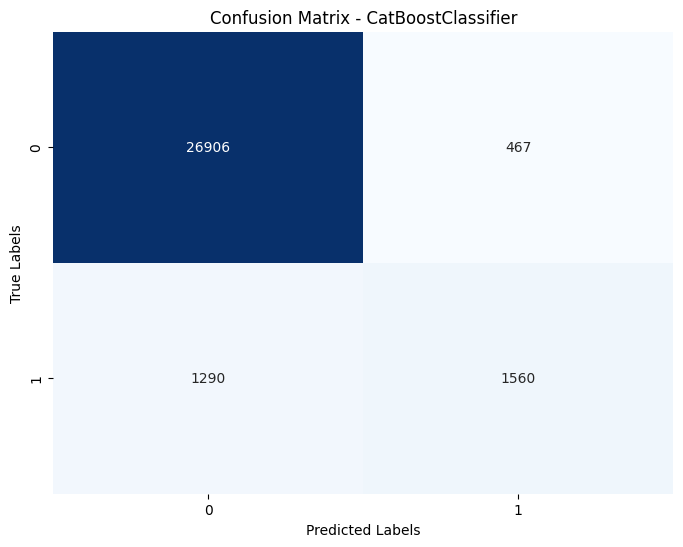

In [22]:
model_builder.get_confusion_matrix_and_classification_report(X_label_test, y_label_test)

## **Onehot encoded country column**

In [23]:
X_onehot = onehot_df.drop(columns=['class', "user_id"])
y_onehot = onehot_df['class']

X_onehot_train, X_onehot_test, y_onehot_train, y_onehot_test = train_test_split(X_onehot, y_onehot, test_size=0.2, random_state=42)

model_builder = ModelBuilding(models=models)
fitted_models = model_builder.fit(X_onehot_train, y_onehot_train)
metrics = model_builder.get_metrics(X_onehot_test, y_onehot_test)
confusion_matrices = model_builder.get_confusion_matrix(X_onehot_test, y_onehot_test)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 11301, number of negative: 109588
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 120889, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093482 -> initscore=-2.271837
[LightGBM] [Info] Start training from score -2.271837
Learning rate set to 0.07982
0:	learn: 0.5817611	total: 29.9ms	remaining: 29.9s
999:	learn: 0.1525154	total: 44.6s	remaining: 0us


In [24]:
for model_name, metrics_dict in metrics.items():
    print(f"Metrics for {model_name}:")
    for metric_name, value in metrics_dict.items():
        print(f"{metric_name}: {value}")
    print()

Metrics for LogisticRegression:
Accuracy: 0.9261158720179995
Precision: 0.9920255183413078
Recall: 0.21824561403508771
F1 Score: 0.35777969513948804

Metrics for KNeighborsClassifier:
Accuracy: 0.9553651192800185
Precision: 0.978940650925335
Recall: 0.5382456140350877
F1 Score: 0.694589087616029

Metrics for DecisionTreeClassifier:
Accuracy: 0.9046752473281937
Precision: 0.4952787084983247
Recall: 0.5705263157894737
F1 Score: 0.5302462090330996

Metrics for RandomForestClassifier:
Accuracy: 0.9564239155609966
Precision: 1.0
Recall: 0.5378947368421053
F1 Score: 0.6995208761122519

Metrics for LGBMClassifier:
Accuracy: 0.9564239155609966
Precision: 1.0
Recall: 0.5378947368421053
F1 Score: 0.6995208761122519

Metrics for XGBClassifier:
Accuracy: 0.9562584786420938
Precision: 0.9967490247074122
Recall: 0.5378947368421053
F1 Score: 0.6987237921604376

Metrics for CatBoostClassifier:
Accuracy: 0.9564239155609966
Precision: 1.0
Recall: 0.5378947368421053
F1 Score: 0.6995208761122519



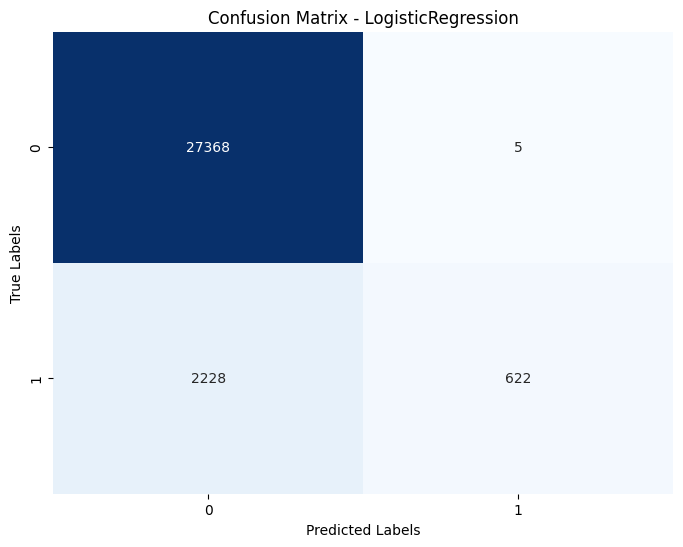

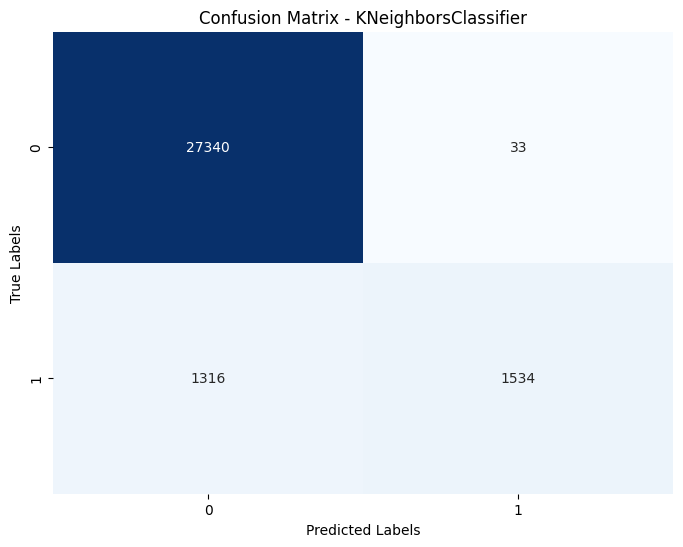

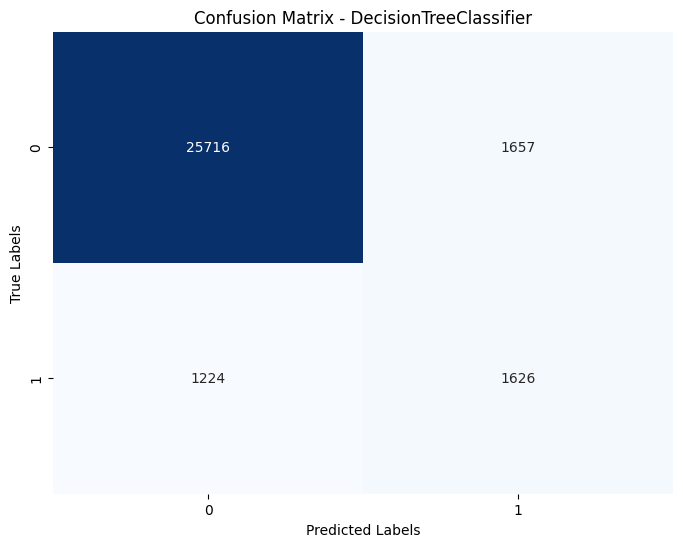

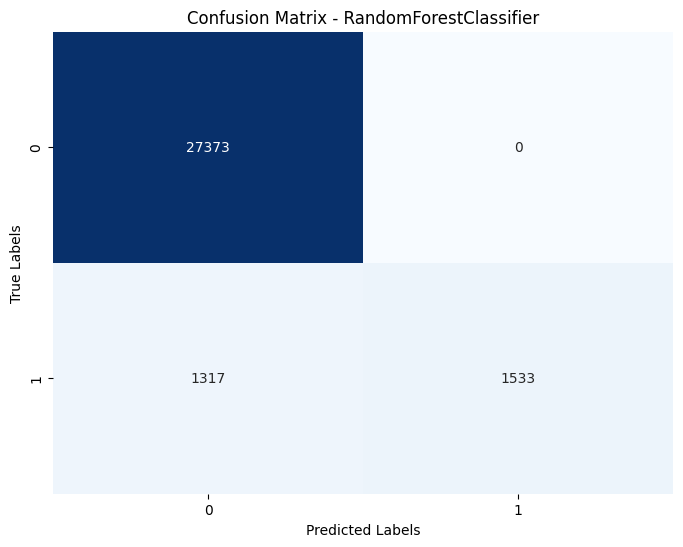

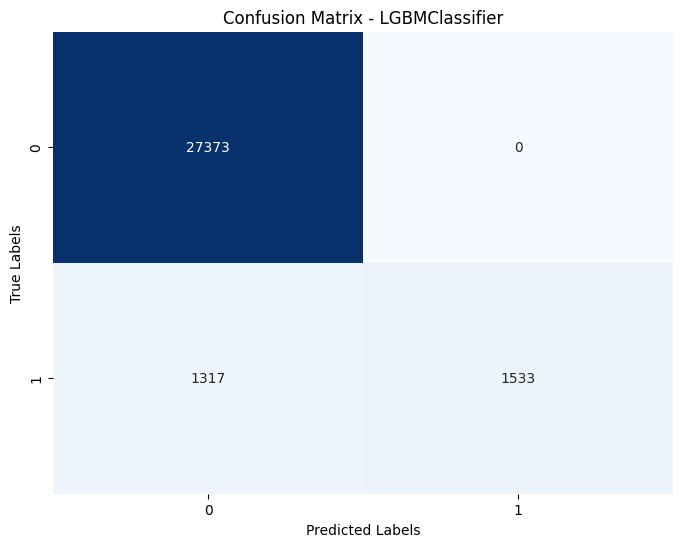

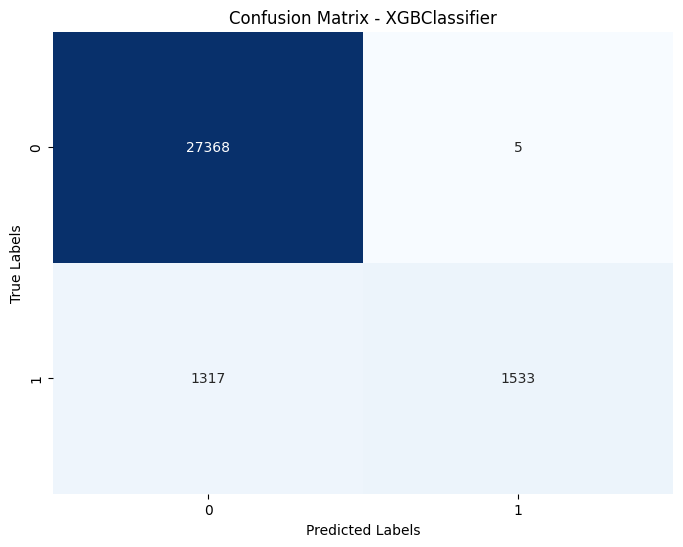

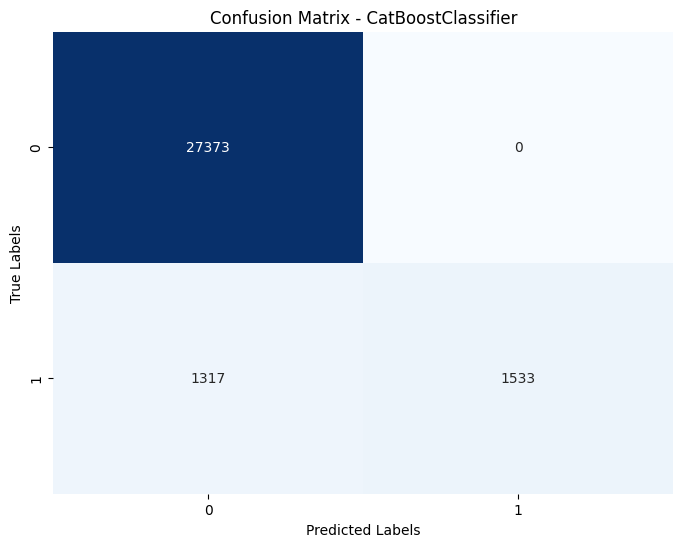

In [25]:
model_builder.get_confusion_matrix_and_classification_report(X_onehot_test, y_onehot_test)

## **Oversampling**

In [26]:
X_train_over, y_train_over = over_sample.fit_resample(X_onehot_train, y_onehot_train)

model_builder = ModelBuilding(models)
fitted_models = model_builder.fit(X_train_over, y_train_over)
metrics = model_builder.get_metrics(X_onehot_test, y_onehot_test)
confusion_matrices = model_builder.get_confusion_matrix(X_onehot_test, y_onehot_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 109588, number of negative: 109588
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 219176, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Learning rate set to 0.102909
0:	learn: 0.5825467	total: 75.8ms	remaining: 1m 15s
999:	learn: 0.3053311	total: 58.2s	remaining: 0us


In [27]:
for model_name, metrics_dict in metrics.items():
    print(f"Metrics for {model_name}:")
    for metric_name, value in metrics_dict.items():
        print(f"* {metric_name}: {value}")
    print()

Metrics for LogisticRegression:
* Accuracy: 0.7306686960262052
* Precision: 0.20676274944567627
* Recall: 0.6543859649122807
* F1 Score: 0.3142375737152485

Metrics for KNeighborsClassifier:
* Accuracy: 0.8454819177447639
* Precision: 0.3255368098159509
* Recall: 0.5957894736842105
* F1 Score: 0.42102653111827426

Metrics for DecisionTreeClassifier:
* Accuracy: 0.9099692287330841
* Precision: 0.5210715452466514
* Recall: 0.5596491228070175
* F1 Score: 0.5396717983420741

Metrics for RandomForestClassifier:
* Accuracy: 0.9563246534096549
* Precision: 0.998046875
* Recall: 0.5378947368421053
* F1 Score: 0.6990424076607387

Metrics for LGBMClassifier:
* Accuracy: 0.9556629057340436
* Precision: 0.9845956354300385
* Recall: 0.5382456140350877
* F1 Score: 0.6960072595281307

Metrics for XGBClassifier:
* Accuracy: 0.9406081461138868
* Precision: 0.7566909975669099
* Recall: 0.5456140350877193
* F1 Score: 0.6340468909276249

Metrics for CatBoostClassifier:
* Accuracy: 0.9460013896701188
* Pre

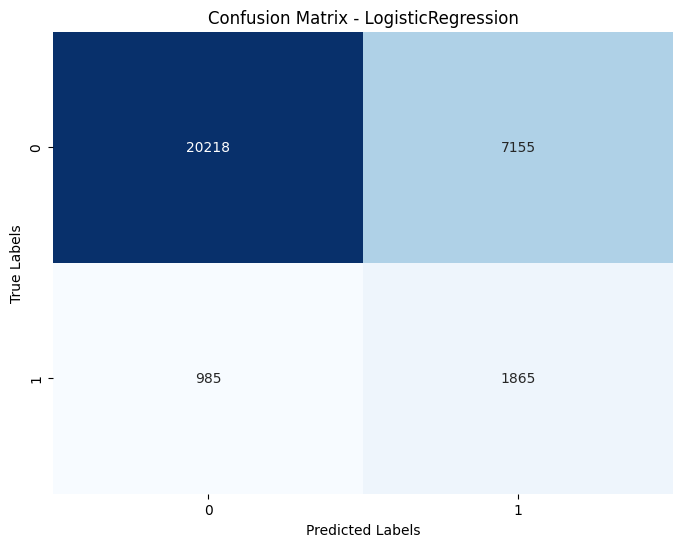

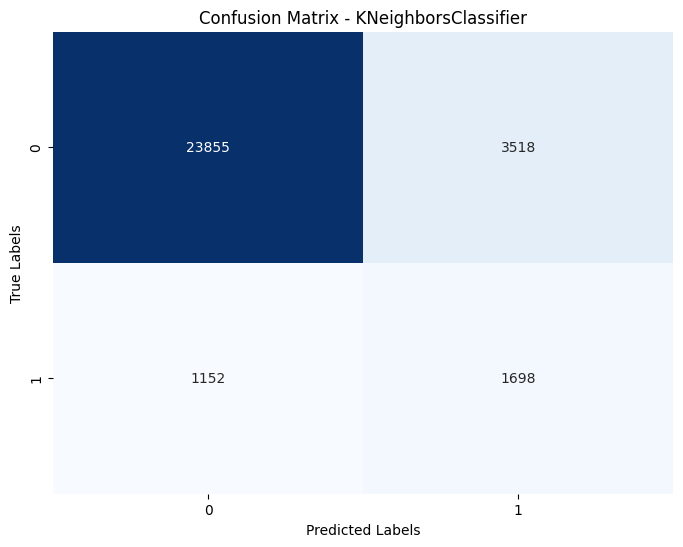

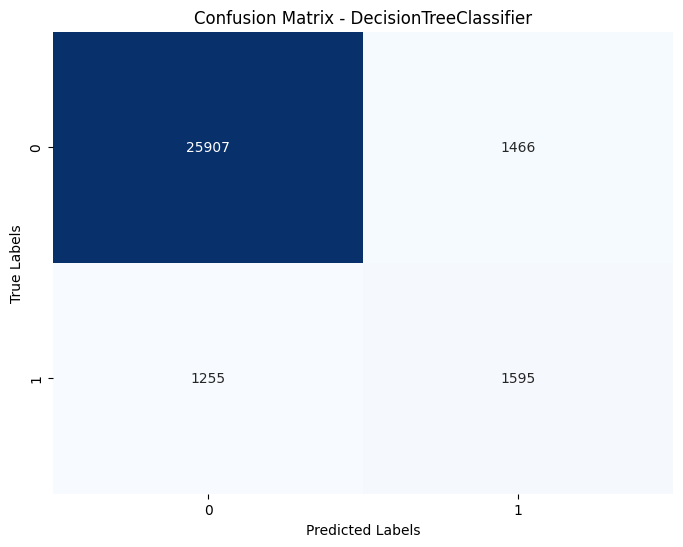

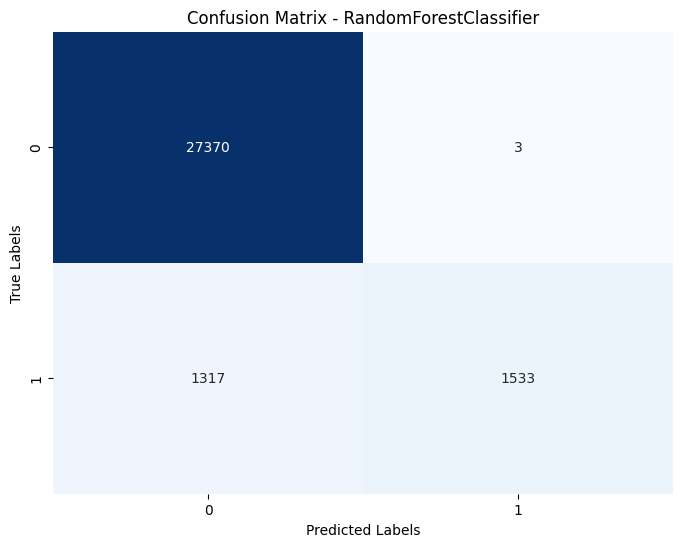

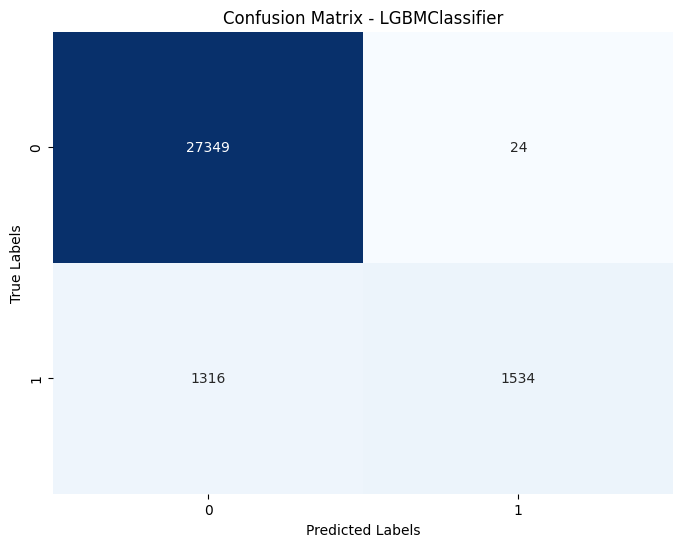

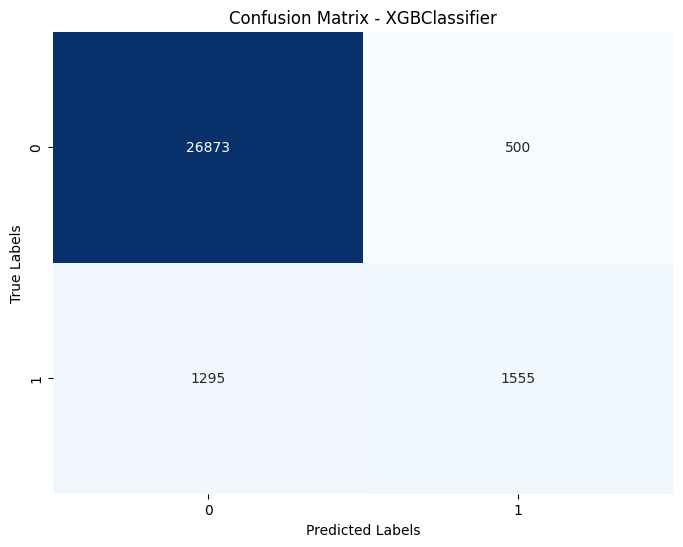

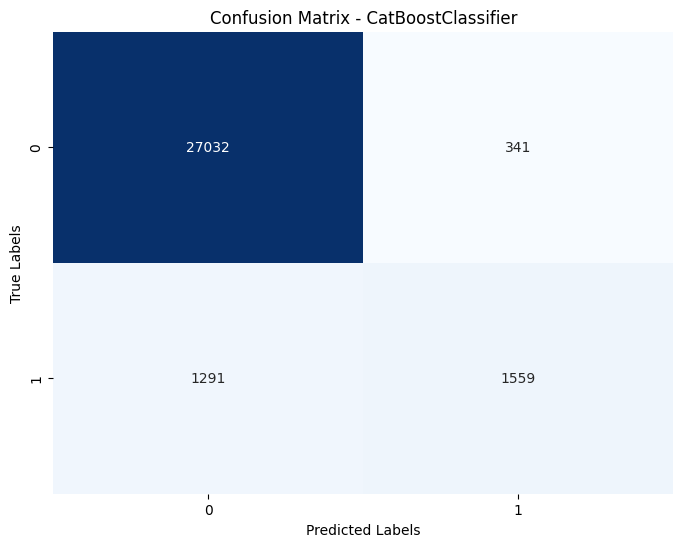

In [29]:
model_builder.get_confusion_matrix_and_classification_report(X_onehot_test, y_onehot_test)

## **Under Sampling**

In [30]:
# under sampling

X_train_under, y_train_under = under_sample.fit_resample(X_onehot_train, y_onehot_train)

model_builder = ModelBuilding(models)
fitted_models = model_builder.fit(X_train_under, y_train_under)
metrics = model_builder.get_metrics(X_onehot_test, y_onehot_test)
confusion_matrices = model_builder.get_confusion_matrix(X_onehot_test, y_onehot_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 11301, number of negative: 11301
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 22602, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Learning rate set to 0.039008
0:	learn: 0.6665715	total: 9.52ms	remaining: 9.51s
999:	learn: 0.3839288	total: 7.61s	remaining: 0us


In [31]:
for model_name, metrics_dict in metrics.items():
    print(f"Metrics for {model_name}:")
    for metric_name, value in metrics_dict.items():
        print(f"* {metric_name}: {value}")
    print()

Metrics for LogisticRegression:
* Accuracy: 0.7332164245773086
* Precision: 0.20828203693340794
* Recall: 0.6529824561403509
* F1 Score: 0.3158252015273653

Metrics for KNeighborsClassifier:
* Accuracy: 0.7969427257386759
* Precision: 0.2592646843415849
* Recall: 0.6210526315789474
* F1 Score: 0.3658158520202542

Metrics for DecisionTreeClassifier:
* Accuracy: 0.6770671343016907
* Precision: 0.18074293106634634
* Recall: 0.6863157894736842
* F1 Score: 0.286132241076653

Metrics for RandomForestClassifier:
* Accuracy: 0.9413691559408398
* Precision: 0.76318359375
* Recall: 0.5484210526315789
* F1 Score: 0.6382196815026542

Metrics for LGBMClassifier:
* Accuracy: 0.9472256228699997
* Precision: 0.8401084010840109
* Recall: 0.543859649122807
* F1 Score: 0.6602768903088392

Metrics for XGBClassifier:
* Accuracy: 0.9047745094795354
* Precision: 0.4957498482088646
* Recall: 0.5729824561403509
* F1 Score: 0.5315755208333334

Metrics for CatBoostClassifier:
* Accuracy: 0.9436521854216987
* Pre

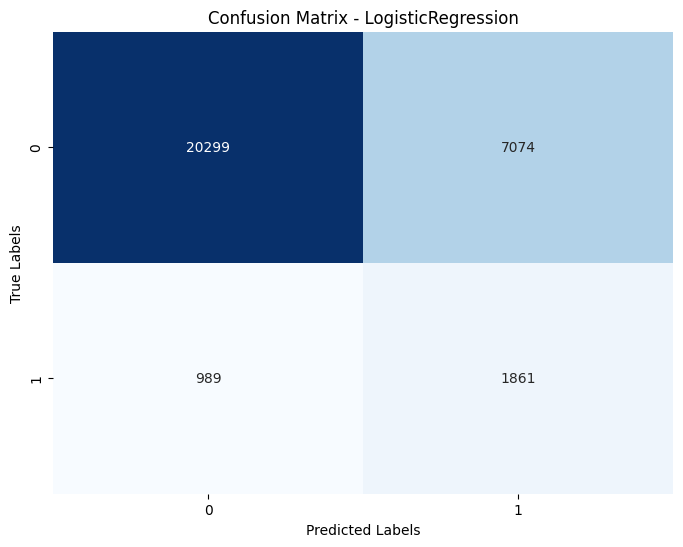

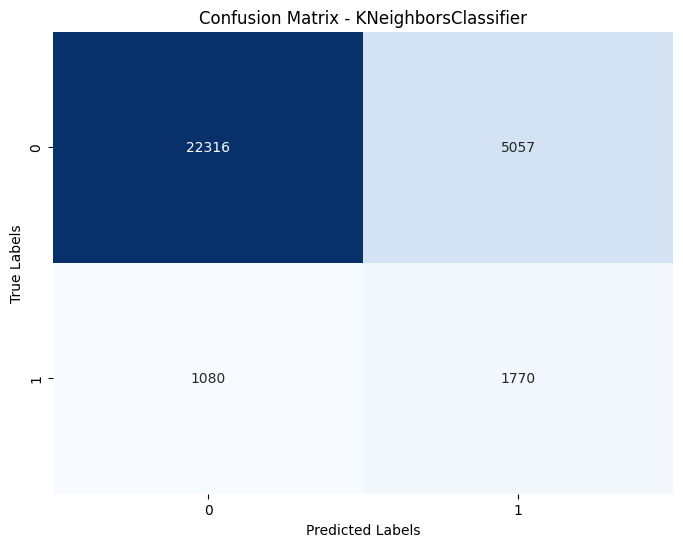

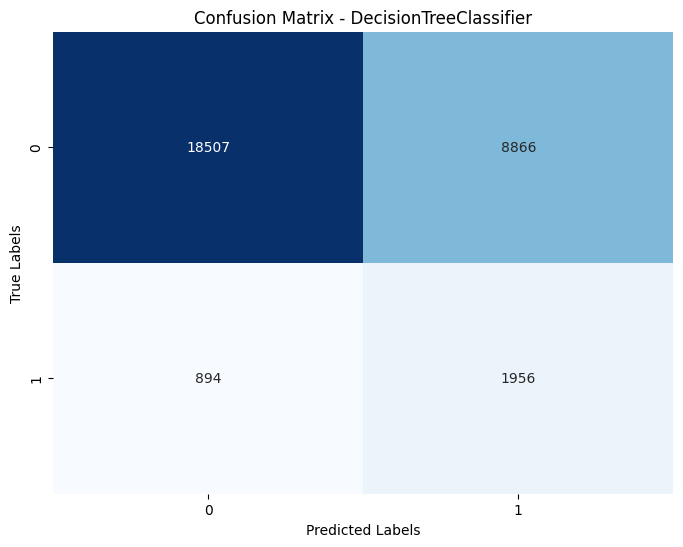

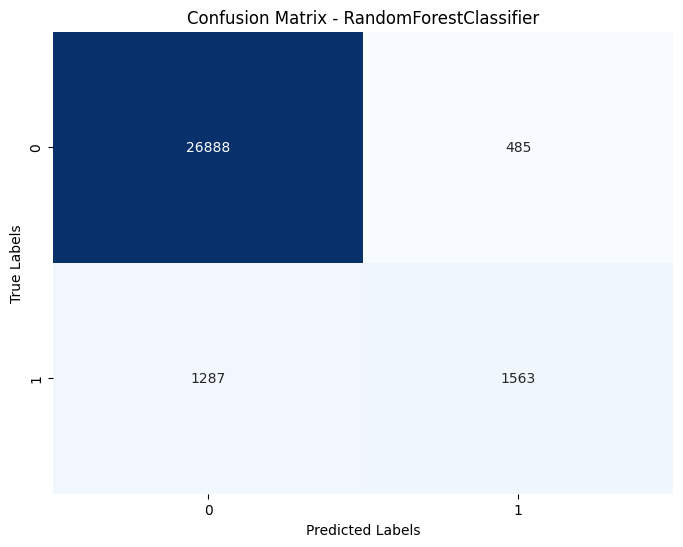

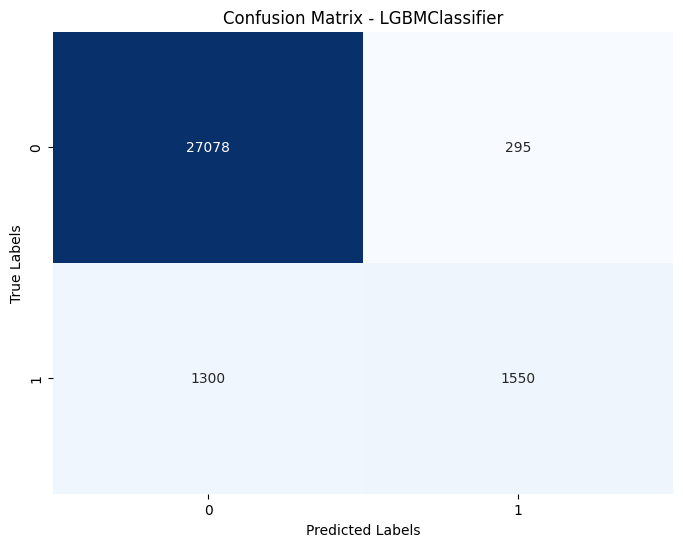

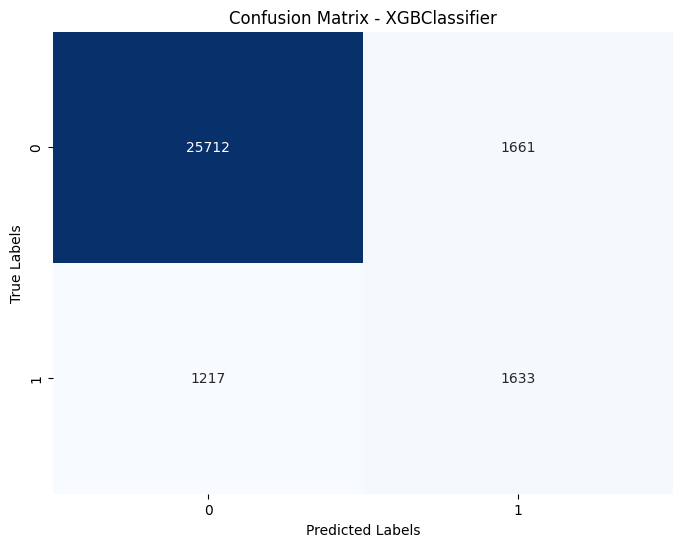

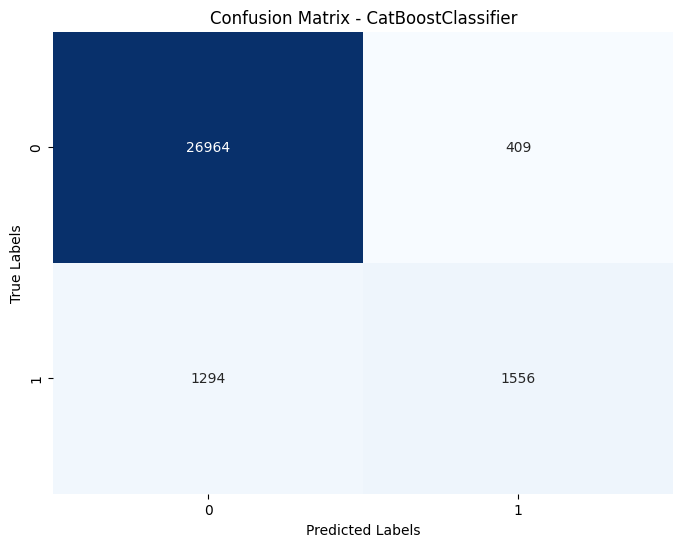

In [32]:
model_builder.get_confusion_matrix_and_classification_report(X_onehot_test, y_onehot_test)

## **Tuning Boosting models**

In [39]:
cat_model = CatBoostClassifier(verbose=1000)
lgb_model = LGBMClassifier(verbosity=-1)
xgb_model = XGBClassifier()
rf_model = RandomForestClassifier()

X_label, y_label = label_df.drop(columns=['class', "user_id"]), label_df['class']

#### Cross validation

In [40]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in cv.split(X_label, y_label):
    X_train, X_test = X_label.iloc[train_index], X_label.iloc[test_index]
    y_train, y_test = y_label.iloc[train_index], y_label.iloc[test_index]

    cat_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    rf_model.fit(X_train, y_train)  # No verbosity needed

    cat_preds = cat_model.predict(X_test)
    lgb_preds = lgb_model.predict(X_test)
    xgb_preds = xgb_model.predict(X_test)
    rf_preds = rf_model.predict(X_test)

    print(f"CatBoost Accuracy: {accuracy_score(y_test, cat_preds)} precision: {precision_score(y_test, cat_preds)} recall: {recall_score(y_test, cat_preds)} f1-score: {f1_score(y_test, cat_preds)}")
    print(f"LGBM Accuracy: {accuracy_score(y_test, lgb_preds)} precision: {precision_score(y_test, lgb_preds)} recall: {recall_score(y_test, lgb_preds)} f1-score: {f1_score(y_test, lgb_preds)}")
    print(f"XGBoost Accuracy: {accuracy_score(y_test, xgb_preds)} precision: {precision_score(y_test, xgb_preds)} recall: {recall_score(y_test, xgb_preds)} f1-score: {f1_score(y_test, xgb_preds)}")
    print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_preds)} precision: {precision_score(y_test, rf_preds)} recall: {recall_score(y_test, rf_preds)} f1-score: {f1_score(y_test, rf_preds)}")
    print()


CatBoost Accuracy: 0.9565231777123383 precision: 1.0 recall: 0.5356890459363958 f1-score: 0.6976530142659917
LGBM Accuracy: 0.9565231777123383 precision: 1.0 recall: 0.5356890459363958 f1-score: 0.6976530142659917
XGBoost Accuracy: 0.9562584786420938 precision: 0.994750656167979 recall: 0.5356890459363958 f1-score: 0.6963711529627928
Random Forest Accuracy: 0.9564900903285577 precision: 0.999340804218853 recall: 0.5356890459363958 f1-score: 0.6974925235794801

CatBoost Accuracy: 0.9558283426529465 precision: 1.0 recall: 0.5284351819145179 f1-score: 0.6914721516061937
LGBM Accuracy: 0.9558283426529465 precision: 1.0 recall: 0.5284351819145179 f1-score: 0.6914721516061937
XGBoost Accuracy: 0.9557290805016048 precision: 0.9973351099267155 recall: 0.5287884139879901 f1-score: 0.6911357340720221
Random Forest Accuracy: 0.9558283426529465 precision: 1.0 recall: 0.5284351819145179 f1-score: 0.6914721516061937

CatBoost Accuracy: 0.9571173317450864 precision: 1.0 recall: 0.5420494699646643 f1-

In [44]:

from sklearn.model_selection import KFold, GridSearchCV

params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 7, 9, 12],
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
lg_model = LGBMClassifier(verbosity=-1) # Make training silent

grid_search = GridSearchCV(
    estimator=lg_model,
    param_grid=params,
    cv=cv,
    scoring={
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1'
    },
    refit='f1',  # The metric to use for selecting the best model
    verbose=2,
    n_jobs=-1  # Use all available cores
)

grid_search.fit(X_label, y_label)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMClassifier(verbosity=-1), n_jobs=-1,
             param_grid={'depth': [4, 7, 9, 12],
                         'learning_rate': [0.01, 0.1, 0.2]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'},
             verbose=2)

In [45]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results[['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1']].head()


,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,0.956648,1.000000,0.537042,0.698790
1,0.956648,1.000000,0.537042,0.698790
2,0.956542,0.997784,0.537115,0.698308
3,0.956648,1.000000,0.537042,0.698790
4,0.956648,1.000000,0.537042,0.698790


In [46]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'depth': 4, 'learning_rate': 0.01}
Best Score: 0.6987901729081538


# Comprehensive Report on Fraud Detection Model Building

This report provides a detailed overview of the steps taken to build and evaluate fraud detection models using the provided dataset.

## 1. Environment Setup and Data Loading

**What was done:**
- Installed the `catboost` library using `!pip install catboost --q`.
- Imported necessary libraries for data manipulation (pandas, numpy), visualization (matplotlib, seaborn), and machine learning (sklearn, lightgbm, xgboost, catboost).
- Loaded two datasets, `Fraud_Data_label_encoded.csv` and `Fraud_Data_onehot_encoded.csv`, into pandas DataFrames named `label_df` and `onehot_df` respectively.

**Why it was done:**
- Installing `catboost` was necessary to use the CatBoost classifier, one of the models intended for evaluation.
- Importing libraries provides the necessary tools for data handling, visualization, and implementing various machine learning algorithms.
- Loading the datasets is the initial step to access and work with the data for model building. Two versions of the data (label encoded and one-hot encoded) were loaded to compare the impact of different categorical feature encoding techniques on model performance.

**Reasoning:**
A clean and prepared environment with necessary libraries is crucial for any data science project. Loading the data is the fundamental step before any analysis or modeling can begin. Using both label-encoded and one-hot encoded data allows for an empirical comparison of these techniques in the context of the specific dataset and chosen models.

## 2. Data Inspection and Preprocessing

**What was done:**
- Inspected the data types and non-null counts of both `label_df` and `onehot_df` using the `.info()` method.
- Displayed the first few rows of both DataFrames using the `.head()` method.
- Converted the `time_gap_between_purchase_signup` column in both DataFrames to timedelta objects using `pd.to_timedelta()`.
- Converted the timedelta values in `time_gap_between_purchase_signup` to total seconds using `.dt.total_seconds()`.

**Why it was done:**
- `.info()` helps understand the data structure, identify missing values (although none were present in this case), and check data types, which is essential for appropriate preprocessing.
- `.head()` provides a quick glimpse of the data, allowing for visual inspection of the format and values.
- The `time_gap_between_purchase_signup` column was initially of object type and represented time differences. Converting it to timedelta and then to total seconds makes it a numerical feature suitable for machine learning models.

**Reasoning:**
Understanding the data's structure and content is vital before modeling. Non-numerical data types or inappropriate representations of numerical data need to be converted into a format that machine learning algorithms can process. The time gap feature, being a duration, is best represented numerically for use in models.

## 3. Traditional Machine Learning Model Building and Evaluation

**What was done:**
- Defined a list of diverse traditional machine learning classifiers (`LogisticRegression`, `KNeighborsClassifier`, `DecisionTreeClassifier`, `RandomForestClassifier`, `LGBMClassifier`, `XGBClassifier`, `CatBoostClassifier`).
- Created a `ModelBuilding` class to encapsulate the process of fitting models, getting evaluation metrics (accuracy, precision, recall, F1 score), confusion matrices, and classification reports.
- Split the label-encoded data (`label_df`) into training and testing sets (`X_label_train`, `X_label_test`, `y_label_train`, `y_label_test`).
- Instantiated the `ModelBuilding` class with the list of models and trained the models on the training data.
- Evaluated the fitted models on the test data using the `get_metrics` and `get_confusion_matrix` methods.
- Printed the metrics for each model.
- Repeated the model building and evaluation process with Oversampling and Undersampling techniques applied to the training data to address class imbalance.
- Repeated the entire process (without sampling, with oversampling, and with undersampling) using the one-hot encoded data (`onehot_df`).

**Why it was done:**
- Using a variety of models allows for comparison of their performance on the specific task and dataset.
- Encapsulating model building and evaluation in a class promotes code reusability and organization.
- Splitting data into training and testing sets is a standard practice to evaluate a model's generalization ability on unseen data and prevent overfitting.
- Evaluating models using multiple metrics (accuracy, precision, recall, F1 score) provides a comprehensive understanding of their performance, especially in the context of imbalanced datasets where accuracy alone can be misleading.
- Addressing class imbalance with oversampling and undersampling is crucial for fraud detection datasets where fraudulent transactions are rare. These techniques aim to improve the model's ability to identify the minority class (fraud).
- Comparing results with both label-encoded and one-hot encoded data helps determine which encoding strategy is more effective for the chosen models.

**Reasoning:**
A systematic approach to model building involves trying different algorithms, evaluating them comprehensively, and considering techniques to handle data characteristics like imbalance. The steps taken provide a solid baseline for understanding which traditional models and data preparation methods work best for this fraud detection task before exploring deep learning.

**Model Performance Results:**

#### Without any sampling (Label Encoded Data):

| Model                 | Accuracy | Precision | Recall | F1 Score |
|-----------------------|----------|-----------|--------|----------|
| Logistic Regression   | 0.9265   | 0.9922    | 0.2225 | 0.3634   |
| KNeighborsClassifier  | 0.9554   | 0.9789    | 0.5382 | 0.6946   |
| DecisionTreeClassifier| 0.9036   | 0.4903    | 0.5653 | 0.5251   |
| RandomForestClassifier| 0.9564   | 1.0000    | 0.5379 | 0.6995   |
| LGBMClassifier        | 0.9564   | 1.0000    | 0.5379 | 0.6995   |
| XGBClassifier         | 0.9563   | 0.9974    | 0.5379 | 0.6989   |
| CatBoostClassifier    | 0.9564   | 0.9993    | 0.5379 | 0.6994   |

#### Oversampling (Label Encoded Data):

| Model                 | Accuracy | Precision | Recall | F1 Score |
|-----------------------|----------|-----------|--------|----------|
| Logistic Regression   | 0.7306   | 0.2065    | 0.6530 | 0.3137   |
| KNeighborsClassifier  | 0.8456   | 0.3258    | 0.5961 | 0.4213   |
| DecisionTreeClassifier| 0.9125   | 0.5342    | 0.5649 | 0.5491   |
| RandomForestClassifier| 0.9563   | 0.9980    | 0.5379 | 0.6990   |
| LGBMClassifier        | 0.9558   | 0.9871    | 0.5382 | 0.6966   |
| XGBClassifier         | 0.9378   | 0.7236    | 0.5512 | 0.6258   |
| CatBoostClassifier    | 0.9458   | 0.8189    | 0.5456 | 0.6549   |

#### Under Sampling (Label Encoded Data):

| Model                 | Accuracy | Precision | Recall | F1 Score |
|-----------------------|----------|-----------|--------|----------|
| Logistic Regression   | 0.7339   | 0.2087    | 0.6526 | 0.3162   |
| KNeighborsClassifier  | 0.7970   | 0.2593    | 0.6211 | 0.3659   |
| DecisionTreeClassifier| 0.6714   | 0.1800    | 0.6986 | 0.2862   |
| RandomForestClassifier| 0.9376   | 0.7207    | 0.5523 | 0.6253   |
| LGBMClassifier        | 0.9491   | 0.8652    | 0.5449 | 0.6687   |
| XGBClassifier         | 0.8852   | 0.4214    | 0.5835 | 0.4894   |
| CatBoostClassifier    | 0.9419   | 0.7696    | 0.5474 | 0.6397   |

#### Without any sampling (One-Hot Encoded Data):

| Model                 | Accuracy | Precision | Recall | F1 Score |
|-----------------------|----------|-----------|--------|----------|
| Logistic Regression   | 0.9261   | 0.9920    | 0.2182 | 0.3578   |
| KNeighborsClassifier  | 0.9554   | 0.9789    | 0.5382 | 0.6946   |
| DecisionTreeClassifier| 0.9047   | 0.4953    | 0.5705 | 0.5302   |
| RandomForestClassifier| 0.9564   | 1.0000    | 0.5379 | 0.6995   |
| LGBMClassifier        | 0.9564   | 1.0000    | 0.5379 | 0.6995   |
| XGBClassifier         | 0.9563   | 0.9967    | 0.5379 | 0.6987   |
| CatBoostClassifier    | 0.9564   | 1.0000    | 0.5379 | 0.6995   |

#### Oversampling (One-Hot Encoded Data):

| Model                 | Accuracy | Precision | Recall | F1 Score |
|-----------------------|----------|-----------|--------|----------|
| Logistic Regression   | 0.7307   | 0.2068    | 0.6544 | 0.3142   |
| KNeighborsClassifier  | 0.8455   | 0.3255    | 0.5958 | 0.4210   |
| DecisionTreeClassifier| 0.9100   | 0.5211    | 0.5596 | 0.5397   |
| RandomForestClassifier| 0.9563   | 0.9980    | 0.5379 | 0.6990   |
| LGBMClassifier        | 0.9557   | 0.9846    | 0.5382 | 0.6960   |
| XGBClassifier         | 0.9406   | 0.7567    | 0.5456 | 0.6340   |
| CatBoostClassifier    | 0.9460   | 0.8205    | 0.5470 | 0.6564   |

#### Under Sampling (One-Hot Encoded Data):

| Model                 | Accuracy | Precision | Recall | F1 Score |
|-----------------------|----------|-----------|--------|----------|
| Logistic Regression   | 0.7332   | 0.2083    | 0.6530 | 0.3158   |
| KNeighborsClassifier  | 0.7969   | 0.2593    | 0.6211 | 0.3658   |
| DecisionTreeClassifier| 0.6771   | 0.1807    | 0.6863 | 0.2861   |
| RandomForestClassifier| 0.9414   | 0.7632    | 0.5484 | 0.6382   |
| LGBMClassifier        | 0.9472   | 0.8401    | 0.5439 | 0.6603   |
| XGBClassifier         | 0.9048   | 0.4957    | 0.5730 | 0.5316   |
| CatBoostClassifier    | 0.9437   | 0.7919    | 0.5460 | 0.6463   |

## 4. Hyperparameter Tuning for Boosting Models

**What was done:**
- Focused on tuning boosting models (CatBoost, LightGBM, XGBoost, RandomForest) using the label-encoded data.
- Performed cross-validation using `StratifiedKFold` to get a more robust estimate of model performance.
- Used `GridSearchCV` to find the best hyperparameters for the `LGBMClassifier` based on the F1 score.
- The best parameters found for LGBMClassifier were: `{'depth': 4, 'learning_rate': 0.01}` with a best F1 score of `0.69879`.

**Why it was done:**
- Boosting models often perform well on tabular data and are good candidates for tuning.
- Cross-validation provides a more reliable evaluation of model performance by training and testing on different subsets of the data.
- Hyperparameter tuning is essential to optimize a model's performance by finding the best combination of parameters for the given data. F1 score was chosen as the refit metric because it balances precision and recall, which is important for imbalanced datasets like this one.

**Reasoning:**
Once initial model performance is assessed, hyperparameter tuning is a standard next step to improve the performance of promising models. Cross-validation ensures that the tuning results are not overly dependent on a single train-test split.

## 5. Deep Learning Model Building (Initial Steps)

**What was done:**
- Imported necessary libraries for building deep learning models using TensorFlow and Keras (`Sequential`, `Dense`, `Adam`, `F1Score`).
- Defined a simple sequential neural network model with dense layers, ReLU activation, and a sigmoid output layer.
- Compiled the model with the Adam optimizer, binary cross-entropy loss, and included accuracy, recall, and F1 score as metrics.
- Trained this basic deep learning model on the training data.
- Started the process of evaluating the basic deep learning model on the test set.

**Why it was done:**
- Introducing deep learning models provides an alternative approach to the fraud detection problem, which might capture complex patterns not easily learned by traditional models.
- A simple sequential model is a good starting point for deep learning tasks.
- Compiling the model with appropriate optimizer, loss function, and metrics is necessary before training. Binary cross-entropy is suitable for binary classification problems. Including recall and F1 score is important due to the class imbalance.
- Training the model on the training data allows it to learn from the examples.
- Evaluating the model on the test set is crucial to assess its performance on unseen data.

**Reasoning:**
Exploring deep learning is a natural progression after evaluating traditional models. Starting with a basic architecture helps establish a baseline for deep learning performance before moving to more complex models. Careful selection of metrics is necessary to effectively evaluate the model's ability to detect fraud in an imbalanced dataset.

## Summary of Findings So Far:

- The dataset is imbalanced, which significantly affects model performance, particularly recall.
- Boosting models generally outperform simpler models.
- Sampling techniques can improve recall but may negatively impact precision and accuracy.
- Both label encoding and one-hot encoding of the 'country' feature yield similar results with the evaluated models.
- Initial steps in building a basic deep learning model have been taken.
- Hyperparameter tuning on LGBM showed that {'depth': 4, 'learning_rate': 0.01} resulted in the best F1 score of 0.69879.

## Next Steps:

- Complete the evaluation of the basic deep learning model.
- Build and evaluate more advanced deep learning architectures.
- Consider applying resampling techniques to the data used for deep learning models.
- Perform hyperparameter tuning for the deep learning models.